# Skip connection in  [Resnet](https://arxiv.org/abs/1512.03385)

In ResNet architectures, a skip connection, often referred to as a "skip layer," provides a shortcut path for the input tensor to bypass one or more layers in the network.  Instead of directly feeding the output of a layer to the next, the skip connection adds the input tensor to the output of the layer.  Mathematically, this looks like:

`Output = F(Input) + Input`

where `F` represents the transformations performed by one or more layers within the residual block, and `Input` is the activation from the previous layer.

### Benefits of skip connection:

* **Addressing Vanishing/Exploding Gradients:**  The skip connection facilitates the flow of gradients during backpropagation, helping to mitigate the vanishing or exploding gradient problem. The direct path for the gradients allows them to propagate more easily through the network, especially in deep architectures where these problems are more pronounced.  The gradients have an easier path to update weights in earlier layers, allowing the network to learn effectively.

* **Enabling Deeper Networks:**  By easing gradient flow, skip connections enable the training of significantly deeper networks.  Deeper networks, in theory, have greater capacity to learn complex features. Without skip connections, very deep networks are difficult or impossible to train due to vanishing gradients.

* **Improved Optimization:** Skip connections are not simply a shortcut for the data, but a mechanism to optimize the network. The network learns *residual functions* — the difference between the desired output and the input — rather than learning the complete mapping directly.  This allows the network to learn incremental improvements on top of what's already been learned.


NB: The skip connection is a crucial component of ResNet architectures, allowing for the construction and training of extremely deep networks by improving gradient flow and enabling the learning of residual mappings. This has revolutionized the field of Computer Vision which has become the state of the art model and showed competitive results on [Imagenet](https://www.image-net.org/).


## Homework

1. Follow the notebook on Resnet and implement a simple skip layer. Feel free to discuss here.
2. Either you can carry forward your skip layer connection to multiple layers and replace it with our vanilla CNN model. Alternatively, try to make use of already implemented Resnet implementation from torchvision. Link can be found in the notebook.
3. Calculate kappa score and generate ROC curve for each class.

## Schematic figure of Resnet (source:Wikepedia)

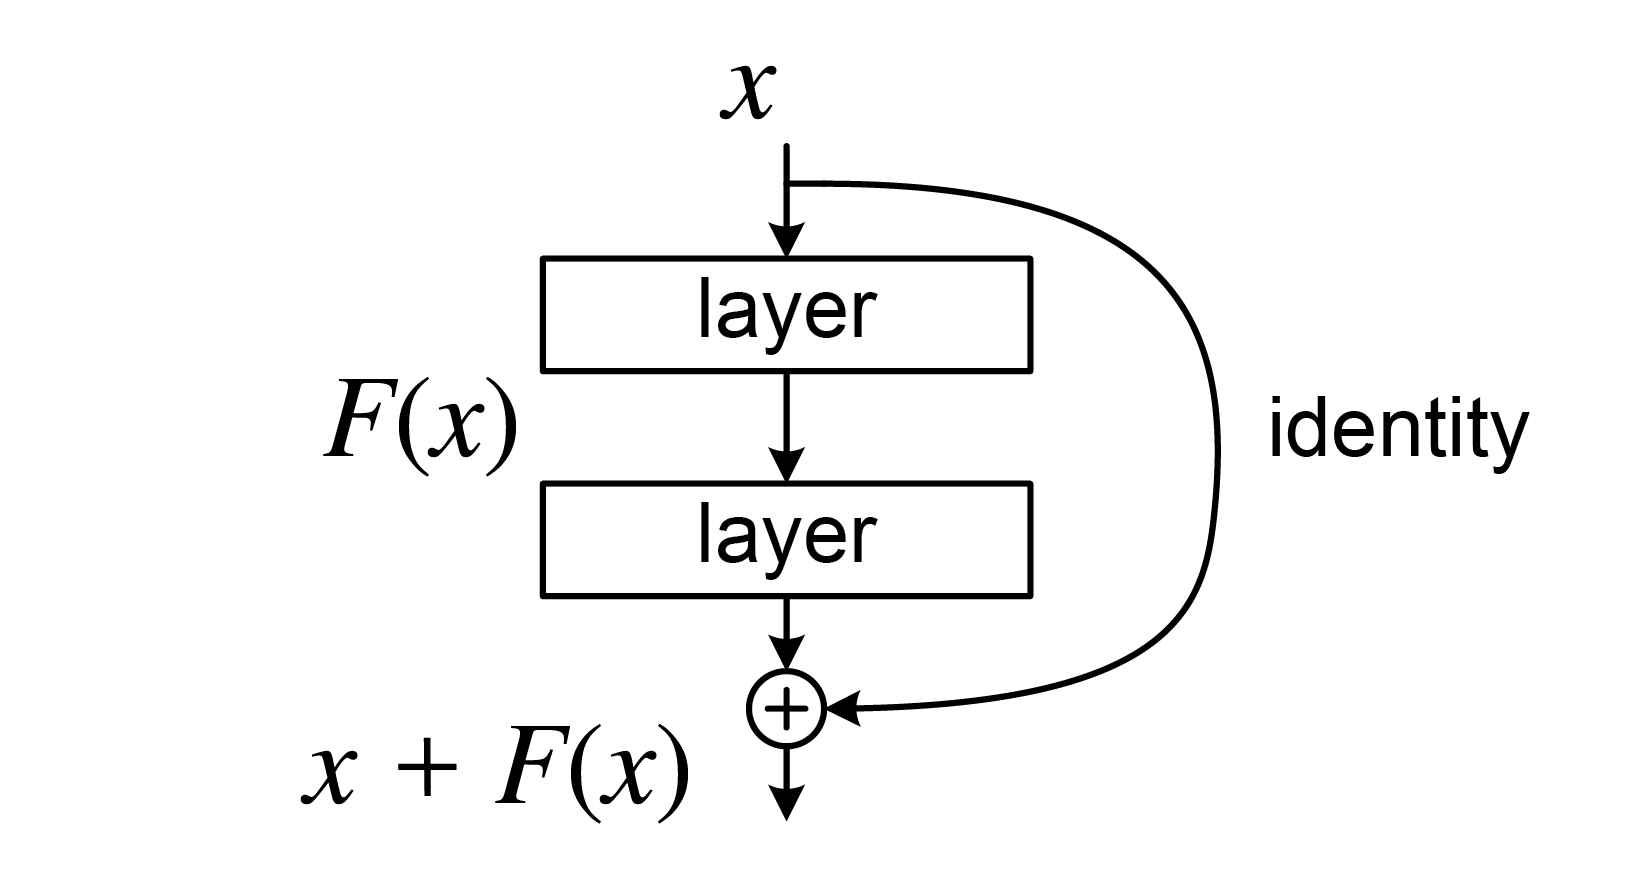

In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, cohen_kappa_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
## Write a torch module for one skip layer as shown in the figure below

## A layer in the figure represent a sequential layer of conv layer -> batchnorm -> Activation function(ReLu)

## We expect by now, you have learnt about different arguments of torch.nn.Conv2D module like in_channels, out_channels, kernel_size, stride, and padding

##import modules whichever required

class SkipLayer(torch.nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size) -> None:
    super().__init__()
    self.layer  = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, in_channels, kernel_size, padding="same"),
      torch.nn.BatchNorm2d(in_channels),
      torch.nn.ReLU()
    )

  def forward(self,x):
    #write your code here
    out = self.layer(x)
    out = self.layer(out)
    out += x
    return out


In [4]:
## Test your module

# 16-batchsize
# 4-channels
# 28 \times 28 - height \times width

random_sample = torch.randn((16,4,28,28))
skip_layer = SkipLayer(4, 4, 5)
print(skip_layer(random_sample).shape)

torch.Size([16, 4, 28, 28])


## Torchvision's Resnet [github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
Now, that you have learnt what is skip connection module, now its time to use a Resnet module to our classification tasks on SAT-6 dataset.

Try to replace our predefined CNN with Resnet. Use already available Resnet module

Hints: The Resnet module from torchvision is developed for RGB images where input image has 3 channels. Please try to change it.

## Data preparation

In [5]:
#!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
#!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
#!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

In [6]:
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
annotations = pd.read_csv("./sat6annotations.csv", header=None)
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)

In [7]:
column_names = labels_df.columns.values
labels = annotations[0].values
num_train = 1000 #replace with -1 if all samples need to be used for training
num_test = 100
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')
num_classes = len(column_names)

number of train indices: 6000, number of test indices: 600


In [8]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

In [9]:
train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([132.58607 , 132.71738 , 129.87779 , 121.028656], dtype=float32),
 array([55.761814, 51.28044 , 47.092102, 65.93346 ], dtype=float32))

In [10]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [11]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

In [12]:
train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

In [13]:
# Use Resnet18 model from torchvision, adapting it to input size of 28x28 pixels and 4 channels

# No weights, because we don't want the pretrained version
resnet = models.resnet18(weights = None)

# Change the in_channels for the first convolution to 4, so it fits our input data
resnet.conv1 = torch.nn.Conv2d(in_channels=4, out_channels= 64, kernel_size=3, stride=1, padding="same")

# Change the last layers output to our number of classes
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

In [14]:
# Test to see if the adaptations work as expected. Output should be of shape (8,6) (batch_size, num_classes)
x = torch.randn(8, 4, 28, 28)
out = resnet(x)
print(out.shape)

torch.Size([8, 6])


In [15]:
print(resnet)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): C

In [16]:
# Put model onto gpu for fast training
resnet = resnet.to(device)

In [17]:
# Set up optimizer, loss function and learning rate scheduler
optimizer = torch.optim.Adam(resnet.parameters(), lr = 0.2)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)

In [18]:
# Training loop
num_epochs = 100
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    resnet.train()
    for train_data_idx, train_data in enumerate(train_dataloader):
      optimizer.zero_grad()
      data, labels = train_data
      data = data.to(device)
      labels = labels.to(device)
      preds = resnet(data)
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      optimizer.step()
    training_loss_per_epoch.append(train_loss.item())

    resnet.eval()
    pred_labels = []
    true_labels = []
    with torch.no_grad():
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = resnet(data)
        val_loss = loss_fn(preds,labels)
        pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
        true_labels.extend(torch.squeeze(labels).to('cpu'))
    validation_loss_per_epoch.append(val_loss.item())
    acc = accuracy_score(true_labels,pred_labels)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")
    scheduler.step()

Epoch 100/100: training_loss : 0.10140268504619598, validation_loss : 0.07653551548719406 and accuracy : 0.9783333333333334 :   0%|          | 0/100 [00:52<?, ?it/s]


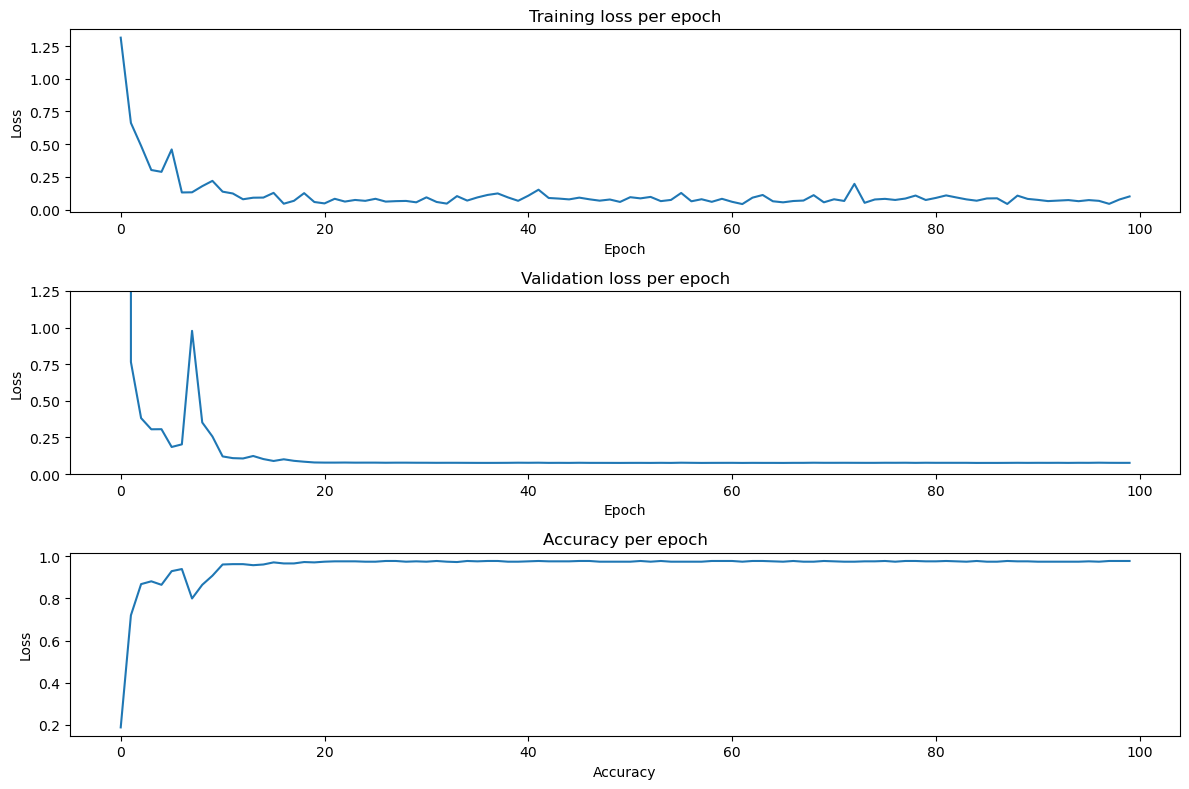

In [28]:
fig, ax = plt.subplots(3, figsize = (12,8))

ax[0].plot(training_loss_per_epoch)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Training loss per epoch")

ax[1].plot(validation_loss_per_epoch)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_ylim([0.0, 1.25])
ax[1].set_title("Validation loss per epoch")

ax[2].plot(acc_per_epoch)
ax[2].set_xlabel("Accuracy")
ax[2].set_ylabel("Loss")
ax[2].set_title("Accuracy per epoch")

plt.tight_layout()
plt.show()


## Calculate kappa score and generate ROC curve for each class.

In [30]:
# Make predictions for test_data
resnet.eval()
pred_labels = []
true_labels = []
with torch.no_grad():
  for test_data_idx, test_data in enumerate(test_dataloader):
    data, labels = test_data
    data = data.to(device)
    labels = labels.to(device)
    preds = resnet(data)
    val_loss = loss_fn(preds,labels)
    pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
    true_labels.extend(torch.squeeze(labels).to('cpu'))


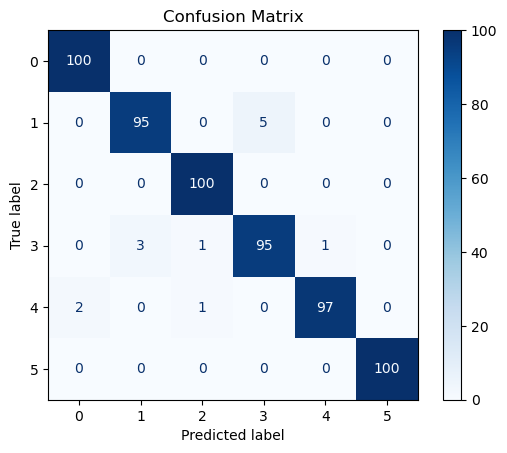

In [31]:
# Visualize results in a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
kappa_score = cohen_kappa_score(true_labels, pred_labels)
print(f"Cohen's Kappa score: {kappa_score}")

Cohen's Kappa score: 0.974


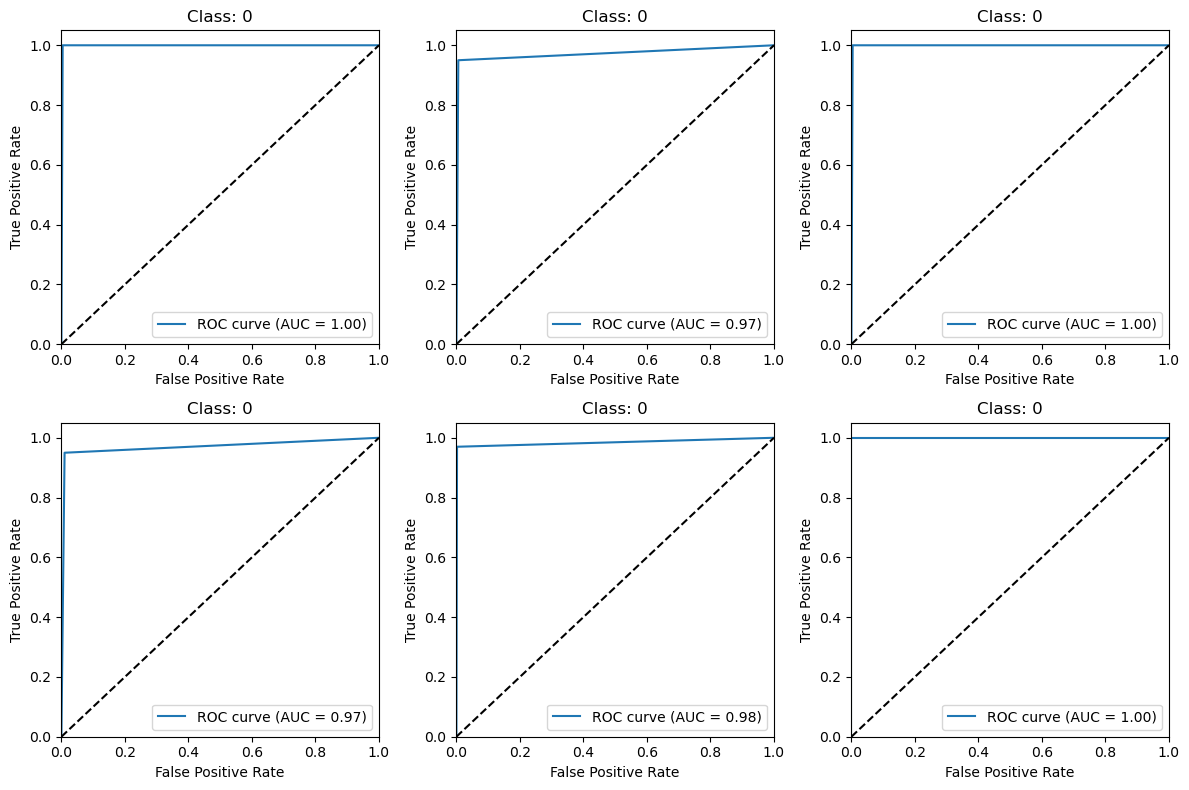

In [33]:
from sklearn.preprocessing import label_binarize
fpr = dict()
tpr = dict()
roc_auc = dict()

binarized_y_true = label_binarize(true_labels, classes=[0,1,2,3,4,5])
binarized_y_pred = label_binarize(pred_labels, classes=[0,1,2,3,4,5])

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_y_true[:, i], binarized_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()  # Flatten to easily iterate

for i in range(num_classes):
    axs[i].plot(fpr[i], tpr[i], label=f"ROC curve (AUC = {roc_auc[i]:.2f})")
    axs[i].plot([0, 1], [0, 1], "k--")
    axs[i].set_xlim([0.0, 1.0])
    axs[i].set_ylim([0.0, 1.05])
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    axs[i].set_title(f"Class: {labels[i]}")
    axs[i].legend(loc="lower right")

plt.tight_layout()
plt.show()